In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Embedding, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from google.colab import drive
import zipfile
import glob
import gc

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile('/content/drive/My Drive/Datasets/Netflix Movies Recommendation/archive.zip') as z:
  z.extractall('.')

In [ ]:
df1 = pd.read_csv('combined_data_1.txt', sep = ',', header = None, names = ['userId', 'rating'], usecols = [0, 1])

In [ ]:
df1

,userId,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [ ]:
df2 = pd.read_csv('combined_data_2.txt', sep = ',', header = None, names = ['userId', 'rating'], usecols = [0, 1])
df3 = pd.read_csv('combined_data_3.txt', sep = ',', header = None, names = ['userId', 'rating'], usecols = [0, 1])
df4 = pd.read_csv('combined_data_4.txt', sep = ',', header = None, names = ['userId', 'rating'], usecols = [0, 1])

In [ ]:
df = pd.concat([df1, df2, df3, df4], axis = 0).reset_index(drop = True)

In [ ]:
del df1, df2, df3, df4 #free up resources
gc.collect()

49

In [ ]:
df.shape

(100498277, 2)

In [ ]:
df

,userId,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [ ]:
df['rating'].value_counts()

4.0    33750958
3.0    28811247
5.0    23168232
2.0    10132080
1.0     4617990
Name: rating, dtype: int64

In [ ]:
pd.isnull(df.rating).value_counts()

False    100480507
True         17770
Name: rating, dtype: int64

In [ ]:
null_rows = df[df['rating'].isnull()]

In [ ]:
null_rows

,userId,rating
0,1:,NaN
548,2:,NaN
694,3:,NaN
2707,4:,NaN
2850,5:,NaN
...,...,...
100488431,17766:,NaN
100489037,17767:,NaN
100489242,17768:,NaN
100490605,17769:,NaN


In [ ]:
df.shape

(100498277, 2)

In [ ]:
#null_rows['userId'] = null_rows['userId'].apply(str)

<ipython-input-13-d87003985d14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_rows['userId'] = null_rows['userId'].apply(str)


In [ ]:
movieIds = np.empty((df.shape[0], 1), dtype = int)

In [ ]:
movieIds.shape[0]

100498277

In [ ]:
null_rows.index

Int64Index([        0,       548,       694,      2707,      2850,      3991,
                 5011,      5105,     20016,     20112,
            ...
            100384778, 100389090, 100421201, 100423159, 100488117, 100488431,
            100489037, 100489242, 100490605, 100497355],
           dtype='int64', length=17770)

In [ ]:
index = 1
value = 1
start = 0
end = null_rows.index[index]

while(index != 17769):

  for row in range(start, end):

    movieIds[row] = value

  value += 1
  index += 1
  start = end
  end = null_rows.index[index]

#manually adding the remaining movieIds
value = 17769
for row in range(100490605, 100498277):
  
  movieIds[row] = value

  if row == 100497354:

    value += 1

In [ ]:
movieIds_df = pd.DataFrame(movieIds, columns = ["movieId"])

In [ ]:
movieIds_df

,movieId
0,1
1,1
2,1
3,1
4,1


In [ ]:
df = pd.concat([df, movieIds_df], axis = 1)

In [ ]:
del movieIds_df, movieIds, null_rows
gc.collect()

0

In [ ]:
df = df[pd.notnull(df['rating'])]

In [ ]:
df = df.reset_index(drop = True)

In [ ]:
df

,userId,rating,movieId
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1
...,...,...,...
100480502,1790158,4.0,17770
100480503,1608708,3.0,17770
100480504,234275,1.0,17770
100480505,255278,4.0,17770


In [ ]:
df.to_csv('processed.csv', index = False)

In [ ]:
!du -h '/content/processed.csv'

1.6G	/content/processed.csv


In [ ]:
gc.collect()

339

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Netflix Movies Recommendation/processed.csv') #restoring saved csv incase of memory crash

In [ ]:
df

,userId,rating,movieId
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1
...,...,...,...
100480502,1790158,4.0,17770
100480503,1608708,3.0,17770
100480504,234275,1.0,17770
100480505,255278,4.0,17770


In [4]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes #converting userId's to categorical since they are not sequential and have gaps in them

In [5]:
user_ids = df['new_user_id'].values
movie_ids = df['movieId'].values
ratings = df['rating'].values

In [6]:
N = len(set(user_ids))
M = len(set(movie_ids))
K = 20 #size of embedding vector space 

In [7]:
u = Input(shape = (1,))
m = Input(shape = (1,))

u_embedding = Embedding(N, K)(u)
m_embedding = Embedding(M, K)(m)

u_embedding = Flatten()(u_embedding)
m_embedding = Flatten()(m_embedding)

x = Concatenate()([u_embedding, m_embedding])
x = Dense(1024, activation = 'relu')(x)
#x = Dense(400, activation = 'relu')(x)
x = Dropout(0.4)(x) #previous dropout 0.2
#x = Dense(400, activation = 'relu')(x)
x = Dense(1)(x)

model = Model(inputs = [u, m], outputs = x)
model.compile(loss = 'mse', optimizer = SGD(learning_rate = 0.08, momentum = 0.9))

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 20)        9603780     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 20)        355400      ['input_2[0][0]']                
                                                                                              

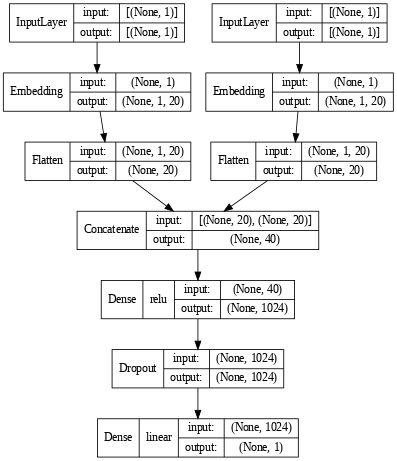

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True, show_layer_names = False, dpi = 60, show_layer_activations = True, rankdir = 'TB')

In [10]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
n_train = int(0.8 * len(ratings))

train_user = user_ids[:n_train]
train_movie = movie_ids[:n_train]
train_ratings = ratings[:n_train]

test_user = user_ids[n_train:]
test_movie = movie_ids[n_train:]
test_ratings = ratings[n_train:]

avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating 
test_ratings = test_ratings - avg_rating

In [12]:
import tensorflow as tf

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

#using GPU since system RAM is limited

with tf.device('/GPU:0'):
  
  r = model.fit(x = [train_user, train_movie],
                y = train_ratings,
                epochs = 25,
                batch_size = 2000,
                verbose = 2,
                validation_data = ([test_user, test_movie], test_ratings),
                callbacks = [early_stop])

Epoch 1/25
40193/40193 - 271s - loss: 0.8785 - val_loss: 0.8206 - 271s/epoch - 7ms/step
Epoch 2/25
40193/40193 - 268s - loss: 0.7967 - val_loss: 0.7836 - 268s/epoch - 7ms/step
Epoch 3/25
40193/40193 - 243s - loss: 0.7721 - val_loss: 0.7702 - 243s/epoch - 6ms/step
Epoch 4/25
40193/40193 - 244s - loss: 0.7594 - val_loss: 0.7615 - 244s/epoch - 6ms/step
Epoch 5/25
40193/40193 - 266s - loss: 0.7466 - val_loss: 0.7494 - 266s/epoch - 7ms/step
Epoch 6/25
40193/40193 - 253s - loss: 0.7320 - val_loss: 0.7391 - 253s/epoch - 6ms/step
Epoch 7/25
40193/40193 - 249s - loss: 0.7202 - val_loss: 0.7324 - 249s/epoch - 6ms/step
Epoch 8/25
40193/40193 - 255s - loss: 0.7106 - val_loss: 0.7262 - 255s/epoch - 6ms/step
Epoch 9/25
40193/40193 - 245s - loss: 0.7008 - val_loss: 0.7190 - 245s/epoch - 6ms/step
Epoch 10/25
40193/40193 - 263s - loss: 0.6920 - val_loss: 0.7151 - 263s/epoch - 7ms/step
Epoch 11/25
40193/40193 - 240s - loss: 0.6846 - val_loss: 0.7097 - 240s/epoch - 6ms/step
Epoch 12/25
40193/40193 - 268s

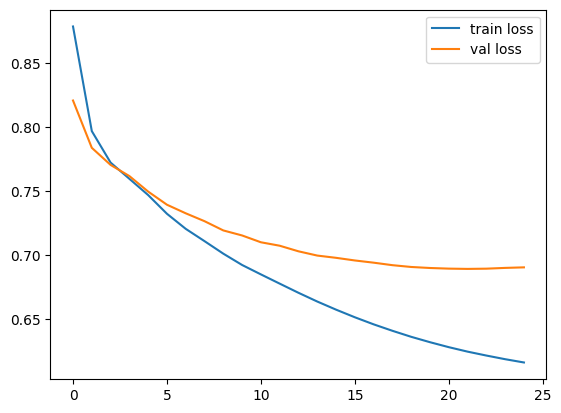

In [13]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

In [16]:
val_loss = r.history['val_loss']

0.6901334524154663

In [17]:
print("RMSE loss is {}".format(np.sqrt(val_loss[-1])))

RMSE loss is 0.8307427113225047


In [23]:
users = np.asarray([1080030])
movies = np.asarray([1])
prediction = model.predict([users, movies])
prediction = (prediction + avg_rating)
print(prediction)

1/1 [==============================] - 0s 23ms/step
[[3.7926576]]
